# Построение и оптимизация модели

В этом задании вам предстоит поучаствовать в соревновании на [kaggle inclass](https://inclass.kaggle.com/c/telecom-clients-churn-prediction).
В соревновании вы будете работать с той же выборкой, что и ранее, поэтому воспользуйтесь результатами, полученными на предыдущих неделях. Для успешного участия в соревновании необходимо преодолеть по качеству beseline решение.

Итак, мы научились обрабатывать данные, выбрали схему кросс-валидации и определились с метриками качества. Пора переходить к оптимизации модели. На этой неделе вам предстоит принять участие в соревновании на платформе kaggle inclass! Цель такого соревнования - преодолеть предложенное baseline решение, а, главное, обсудить и сравнить предложенные решения на форуме. Какие признаки оказали наибольший вклад в модель? Как лучше обрабатывать категориальные признаки? Нужно ли делать отбор признаков, А балансировать выборку? Экспериментируйте с данными и обсуждайте ваши решения на форуме!

In [1]:
import pandas as pd
import random
import numpy as np
from scipy.sparse import coo_matrix, hstack
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, recall_score, precision_score, log_loss

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

seed = 1903
first_categorial_index = 190

Загрузим train dataset.

In [73]:
churn_data_frame = pd.read_csv("..\..\Data\churn_data_train.csv", ",")
churn_labels_frame = pd.read_csv("..\..\Data\churn_labels_train.csv")
y = churn_labels_frame.as_matrix().flatten()
print(churn_data_frame.shape)
print(churn_labels_frame.shape)

(27999, 230)
(27999, 1)


## Общая предобработка признаков

In [62]:
def scale_frame(frame):
    """Функция масштабирает frame на отрезок [0;1]"""
    scaler = StandardScaler()
    scaled_matrix = scaler.fit_transform(frame.as_matrix())
    return pd.DataFrame(scaled_matrix, columns=frame.columns)

def fill_numericna(frame, averageCalculator):
    """ Функция заполняет значения в числовом фрейме значениями, посчитанными averageCalculator. """
    n_frame = frame
    
    # Посчитаем средние по колонкам
    numeric_avgs = averageCalculator(n_frame)
    # Оставим только те колонки, в которых среднее значение не равно NaN, т.к. в таких колонках совсем нет значений
    numeric_avgs = numeric_avgs.dropna()
    dropped_columns = n_frame.columns.drop(numeric_avgs.index)
    n_frame = n_frame[list(numeric_avgs.index)]
    # Заполним пропущенные численные значения средними
    n_frame = n_frame.fillna(numeric_avgs, axis=0)
    return (n_frame, dropped_columns)

def fill_numericna_means(frame):
    """ Функция заполняет значения в числовом фрейме средними и удаляет те колонки, в которых значений нет. """
    return fill_numericna(frame, lambda f: f.mean(axis=0, skipna=True))

def fill_numericna_medians(frame):
    """ Функция заполняет значения в числовом фрейме медианами и удаляет те колонки, в которых значений нет. """
    return fill_numericna(frame, lambda f: f.median(axis=0, skipna=True))
    
def remove_constant_features(frame):
    """Функция удаляет колонки, которые содержат только одно значение."""
    
    # Посчитаем количества уникальных значений по колонкам
    unique_counts = frame.nunique()
    # Удалим колонки с одним уникальным значением
    columns_to_drop = unique_counts[unique_counts <= 1].index
    
    return (frame.drop(columns=columns_to_drop), columns_to_drop)

def fill_na_frequent_values(frame):
    """ Функция заполняет пустые значения самым частым значением в колонке. """
    result = frame.copy()
    for column in result.columns:
        frequencies = result[column].value_counts()
        if (len(frequencies) < 1):
            continue
        most_frequent_value = frequencies.index[0]
        result[column] = result[column].fillna(most_frequent_value)
    return result

def label_encode(X_categorial):
    """ Функция кодирует категории числами от 0 до n, где n количество категорий в колонке. """
    X_num = np.empty(X_categorial.shape)
    for column_number in range(X_categorial.shape[1]):
        labelEncoder = LabelEncoder()
        column = X_categorial[:,column_number]
        for idx, val in enumerate(column):
            if(not(isinstance(val, str))):
                column[idx] = "NaV"
        num_column = labelEncoder.fit_transform(column)
        for row_number, val in enumerate(num_column):
            X_num[row_number, column_number] = val
    return X_num

Разделим коллекции на группы - числовые и категориальные.

In [8]:
numeric_columns = churn_data_frame.columns[:first_categorial_index]
categorial_columns = churn_data_frame.columns[first_categorial_index:]

numeric_frame = churn_data_frame[numeric_columns].copy()
categorial_frame = churn_data_frame[categorial_columns].copy()

Удалим вещественные колонки, содержащие одно и менее значений

In [9]:
numeric_frame_no_const, dropped_const_numeric_columns = remove_constant_features(numeric_frame)

Заполним пропущенные вещественные значения средними

In [14]:
numeric_frame_means, dropped_na_numeric_columns = fill_numericna_means(numeric_frame_no_const)
numeric_frame_medians, dropped_na_numeric_columns = fill_numericna_medians(numeric_frame_no_const)

Заполним пропущенные категориальные значения строками "NaV" (Not a value)

In [49]:
categorial_frame_nav = categorial_frame.fillna("NaV")

Заполним пропущенные категориальные значения самым частым значением в колонке

In [63]:
categorial_frame_freq = fill_na_frequent_values(categorial_frame)

Удалим категориальные колонки с одним единственным значением

In [64]:
categorial_frame_nav_no_const, dropped_categorial_columns = remove_constant_features(categorial_frame_nav)
categorial_frame_freq_no_const, dropped_categorial_freq_columns = remove_constant_features(categorial_frame_freq)

Список удаленных колонок при заполнении категориальных значений значениями NaV

In [65]:
dropped_columns = np.concatenate([
        list(dropped_const_numeric_columns),
        list(dropped_na_numeric_columns),
        list(dropped_categorial_columns)])
print (", ".join(dropped_columns))

Var8, Var15, Var20, Var31, Var32, Var39, Var42, Var48, Var52, Var55, Var79, Var118, Var141, Var167, Var169, Var175, Var185, Var209, Var230


Список удаленных колонок при заполнении категориальных значений самым частым в колонке

In [66]:
dropped_columns = np.concatenate([
        list(dropped_const_numeric_columns),
        list(dropped_na_numeric_columns),
        list(dropped_categorial_freq_columns)])
print (", ".join(dropped_columns))

Var8, Var15, Var20, Var31, Var32, Var39, Var42, Var48, Var52, Var55, Var79, Var118, Var141, Var167, Var169, Var175, Var185, Var191, Var209, Var213, Var215, Var224, Var230


Закодируем категориальные признаки значениями от 0 до n. Это в любом случае понадобится, т.к. например OneHotEncoder принимает на вход целочисленную матрицу.

In [70]:
categorial_frame_nav_labeled = pd.DataFrame(
    label_encode(categorial_frame_nav_no_const.as_matrix()),
    columns=categorial_frame_nav_no_const.columns)
categorial_frame_freq_labeled = pd.DataFrame(
    label_encode(categorial_frame_freq_no_const.as_matrix()),
    columns=categorial_frame_freq_no_const.columns)

In [72]:
def stratifiedKFold_fscore(X, y, model_factory, seed, folds_count = 3):
    """ Функция разбивает набор данных на folds_count, считает F-меру на каждом фолде и возвращает усредненное по фолдам значение. """
    skf = StratifiedKFold(n_splits=folds_count, shuffle=True, random_state=seed)
    f_score_sum = 0
    # Функция также возвращает модель, показавшую лучшее качество, её метрики и разделение данных
    # Разделение данных нужно для того, чтобы строить метрики модели на данных, на которых она не обучалась.
    best_model = None
    best_score = 0
    best_precision = 0
    best_recall = 0
    best_table = None
    best_split = None
    for train_indices, test_indices in skf.split(X, y):
        X_train = X.tocsc()[train_indices]
        X_test = X.tocsc()[test_indices]
        y_train = y[train_indices]
        y_test = y[test_indices]
        model = model_factory()
        # Обучим модель
        model.fit(X_train, y_train)
        # Построим предсказания для расчета оценки
        y_predicted = model.predict(X_test)
        fscore = f1_score(y_test, y_predicted)
        if(best_model is None or best_score < fscore):
            # В случае, если модель лучше предыдущих сохраним её
            # оценку, модель, матрицу ошибок и разделение данных
            best_score = fscore
            best_model = model
            best_split = (X_train, y_train, X_test, y_test)
        f_score_sum += fscore    
    return (
        float(f_score_sum)/float(folds_count),
        best_model,
        best_score,
        best_split)

def predict_ridge_proba(X, model):
    """ Функция возвращает вероятности предсказаний для класса churn модель Ridge """
    # Поскольку RidgeClassifier не обладает функцией predict_proba приходится считать его вручную
    # Подробнее можно посмотреть здесь:
    # https://www.codesd.com/item/scikit-learn-ridge-classifier-extract-class-probabilities.html
    func = model.decision_function(X)
    return np.exp(func) / (1 + np.exp(func))

def predict_model_proba(X, model):
    """ Функция возвращает вероятности предсказаний для класса churn """
    return list(zip(*model.predict_proba(X)))[1]

def get_model_data(model_with_data):
    """ Функция принимает на вход результат stratifiedKFold_fscore и возвращает только модель и её X_test и y_test """
    model = model_with_data[1]
    split = model_with_data[3]
    X = split[2]
    y = split[3]
    return (model,X,y)

def calculate_metrics(model_with_data, predict_probabilities):
    """ Посчитаем метрики качества для модели """
    model, X, y = get_model_data(model_with_data)
    predictions = model.predict(X)
    probabilities = predict_probabilities(X, model)
    # Считаем F-меру, precision и recall
    fscore = f1_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    # Считаем Log loss
    logLoss = log_loss(y, probabilities)
    # Считаем roc auc score
    rocAuc = roc_auc_score(y, probabilities)
    return (precision,recall,fscore,logLoss,rocAuc)

def transform_to_chart_model(label, model_with_data, predict_probabilities):
    """ Функция принимает на вход заголовок, результат функции stratifiedKFold_fscore и функцию, считающую вероятности
    и возвращает заголовок, вектор ответов и вектор вероятностей для построения графиков """
    model, X, y = get_model_data(model_with_data)
    probabilities = predict_probabilities(X, model)
    return (label, y, probabilities)

def charts_row(model_charts, chart_builder, figsize=(11, 4)):
    """ Функция принимает данные для построения графиков и логику построения одного графика и строит графики в одну строку """
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(model_charts),
        figsize=figsize,
        sharey=True)
    for i, chart_data in enumerate(model_charts):
        ax = axes[i]
        chart_builder(chart_data, ax, i)
    plt.show()
    
def scatter(chart_data, ax, ax_index, T=0.5):
    """ Функция строит график распределения вероятностей по классам """
    label, actual, predicted = chart_data
    ax.scatter(actual, predicted)
    ax.set_xlabel("Labels")
    if ax_index == 0:
        ax.set_ylabel("Predicted probabilities")
    ax.set_title(label)
    ax.plot([-1.1, 1.2], [T, T])
    ax.axis([-1.1, 1.1, -0.1, 1.1])
    
def precision_recal_thresh(chart_data, ax, ax_index):
    """ Функция строит графики значений precision и recall в зависимости от порога """
    label, actual, predicted = chart_data
    prec, rec, thresh = precision_recall_curve(actual, predicted)
    min_len = min([len(prec),len(rec),len(thresh)])
    ax.plot(thresh[:min_len], prec[:min_len], label="precision")
    ax.plot(thresh[:min_len], rec[:min_len], label="recall")
    ax.legend(loc=1)
    ax.set_xlabel("threshold")
    ax.set_title(label)
    
def auc_prc(chart_data, ax, ax_index):
    """ Функция строит график AUC PRC (зависимость precision от recall)"""
    label, actual, predicted = chart_data
    prec, rec, thresh = precision_recall_curve(actual, predicted)
    min_len = min([len(prec),len(rec),len(thresh)])
    ax.plot(rec[:min_len], prec[:min_len])
    ax.set_xlabel("recall")
    if ax_index == 0:
        ax.set_ylabel("precision")
    ax.set_title(label)

def calc_min_distance (actual,predicted):
    """ Функция считает минимальное расстояние до точки [0;1] для AUC ROC """
    fpr,tpr,thr = roc_curve(actual,predicted)
    distance,fpr_v,tpr_v,thr_v = min(zip(np.sqrt((1.-tpr)**2+fpr**2),fpr,tpr,thr), key=lambda d:d[0])
    return (distance,fpr_v,tpr_v,thr_v)
    
def auc_roc(chart_data, ax, ax_index):
    """ Функция строит кривую AUC ROC и отмечает точку, соответствующую минимальному расстоянию до точки [0;1] """
    label, actual, predicted = chart_data
    fpr, tpr, thr = roc_curve(actual, predicted)
    min_dist,min_fpr,min_tpr,_ = calc_min_distance(actual, predicted)
    ax.plot(fpr, tpr, label="ROC AUC curve")
    ax.scatter(min_fpr,min_tpr,color="red")
    ax.set_xlabel("false positive rate")
    if ax_index == 0:
        ax.set_ylabel("true positive rate")
    ax.legend(loc=4)
    ax.set_title(label)

## Масштабировать или нет

Возьмем только вещественные признаки и обучим на них модель. Потом масштабируем их и повторно обучим модель. Сравним результаты и решим, что лучше, - масштабировать признаки или нет.

In [77]:
numeric_frame_means_scaled = scale_frame(numeric_frame_means)
X_numeric_means = coo_matrix(numeric_frame_means.as_matrix())
X_numeric_means_scaled = coo_matrix(numeric_frame_means_scaled.as_matrix())

Ridge

In [78]:
numeric_only_r = stratifiedKFold_fscore(X_numeric_means, y, RidgeClassifier, seed)
numeric_only_scaled_r = stratifiedKFold_fscore(X_numeric_means_scaled, y, RidgeClassifier, seed)
print (numeric_only_r[0], numeric_only_scaled_r[0])

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0 0.0


In [89]:
pd.DataFrame(
    [
        [numeric_only_r[0], numeric_only_r[2]],
        [numeric_only_scaled_r[0], numeric_only_scaled_r[2]]
    ],
    index=["Raw", "Scaled"],
    columns=["Mean", "Best"])

NameError: name 'numeric_only_r' is not defined

Random Forest

In [81]:
numeric_only_f = stratifiedKFold_fscore(X_numeric_means, y, RandomForestClassifier, seed)
numeric_only_scaled_f = stratifiedKFold_fscore(X_numeric_means_scaled, y, RandomForestClassifier, seed)
print (numeric_only_f[0], numeric_only_scaled_f[0])

0.009392905677122332 0.00753037912289381


In [87]:
pd.DataFrame(
    [
        [numeric_only_f[0], numeric_only_f[2]],
        [numeric_only_scaled_f[0], numeric_only_scaled_f[2]]
    ],
    index=["Raw", "Scaled"],
    columns=["Mean", "Best"])

,Mean,Best
Raw,0.009393,0.016807
Scaled,0.007530,0.008499


In [88]:
pd.DataFrame(
    [
        calculate_metrics(numeric_only_f, predict_model_proba),
        calculate_metrics(numeric_only_scaled_f, predict_model_proba)
    ],
    index=["Raw", "Scaled"],
    columns=["Precision", "Recall", "F-Score", "Log Loss", "Roc Auc"])

,Precision,Recall,F-Score,Log Loss,Roc Auc
Raw,0.315789,0.008633,0.016807,1.031994,0.587095
Scaled,0.250000,0.004323,0.008499,1.076561,0.588422


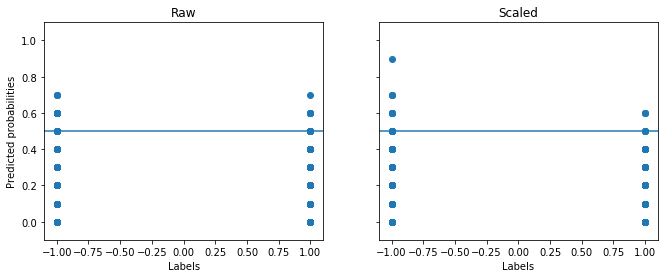

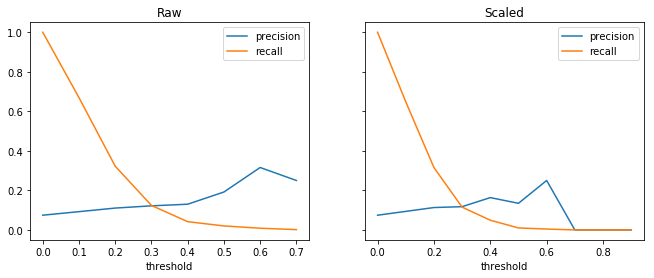

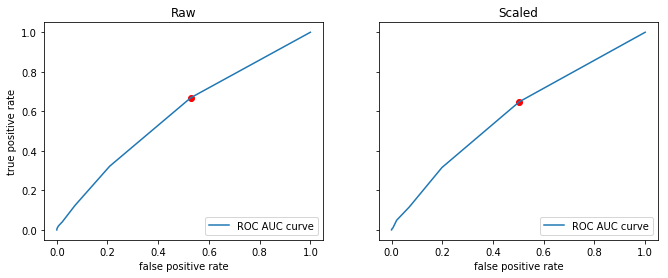

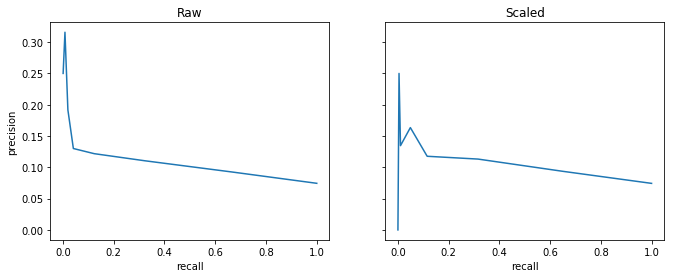

In [91]:
chart_models = [transform_to_chart_model(t, m, pp) for t, m, pp in zip(
    ["Raw", "Scaled"],
    [numeric_only_f, numeric_only_scaled_f],
    [predict_model_proba, predict_model_proba]
)]
charts_row(chart_models, scatter)
charts_row(chart_models, precision_recal_thresh)
charts_row(chart_models, auc_roc)
charts_row(chart_models, auc_prc)

In [92]:
# Написать функцию, сравнивающую два подхода
# Масштабировать
# Oversampling/Undersampling/No sampling
# Удалить признаки не коррелирующие с целевой переменной или добавлять по одному признаку по убыванию корреляции,
#   пока растет качество.
# Удалить признаки сильно коррелирующие друг с другом или удалять по одному, пока растет качество.
# Автоматический отсев признаков

# Для линейной модели попробовать бинаризацию вместо OneHot
# Для остальных попробовать бинаризацию вместо Labeled
# Попробовать другие способы работы с категориальными признаками

# Поискать скоррелированные значения между категориальными и численными признаками